<a href="https://colab.research.google.com/github/FlameHazee/CSC420_Project/blob/master/RecycleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC420 Final Project
## RecycleNet
Tianyang Han (hantia12) – tianyang.han@mail.utoronto.ca

Raymond Truong (truongr6) – raymond.truong@mail.utoronto.ca



---





# Mount Google Drive
Download *dataset-resized.zip* from [here](https://drive.google.com/drive/folders/0B3P9oO5A3RvSUW9qTG11Ul83TEE), courtesy of [Gary Thung](https://github.com/garythung/trashnet), and store it in the root of your Google Drive. 

This block of code will mount Google Drive and extract the zipped dataset into a folder in the root, also called *dataset-resized*.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/dataset-resized.zip" -d "/content/gdrive/My Drive/"
!ls "/content/gdrive/My Drive/dataset-resized/plastic"


Archive:  /content/gdrive/My Drive/dataset-resized.zip
replace /content/gdrive/My Drive/dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: plastic100.jpg	plastic189.jpg	plastic276.jpg	plastic363.jpg	plastic450.jpg
plastic101.jpg	plastic18.jpg	plastic277.jpg	plastic364.jpg	plastic451.jpg
plastic102.jpg	plastic190.jpg	plastic278.jpg	plastic365.jpg	plastic452.jpg
plastic103.jpg	plastic191.jpg	plastic279.jpg	plastic366.jpg	plastic453.jpg
plastic104.jpg	plastic192.jpg	plastic27.jpg	plastic367.jpg	plastic454.jpg
plastic105.jpg	plastic193.jpg	plastic280.jpg	plastic368.jpg	plastic455.jpg
plastic106.jpg	plastic194.jpg	plastic281.jpg	plastic369.jpg	plastic456.jpg
plastic107.jpg	plastic195.jpg	plastic282.jpg	plastic36.jpg	plastic457.jpg
plastic108.jpg	plastic196.jpg	plastic283.jpg	plastic370.jpg	plastic458.jpg
plastic109.jpg	plastic197.jpg	plastic284.jpg	plastic371.jpg	plastic459.jpg
plastic10.jpg	plastic198.jpg	plastic285.jpg	plastic372.jpg	plastic45.jpg
plastic110.jpg	plastic199.j

# Imports and Definitions

In [0]:
%matplotlib inline

import keras.backend as K
import numpy as np
import os
import tensorflow as tf
import h5py
import pydot
import scipy.misc
import matplotlib.pyplot as plt
import cv2
import skimage.io as io
import skimage.transform as trans

from keras import layers
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize, rotate 
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageEnhance
from IPython.display import SVG
from matplotlib.pyplot import imshow

K.set_image_data_format('channels_last')
K.set_learning_phase(1)


waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Using TensorFlow backend.


# Load, Augment and Augment Data

In [0]:
def augment(img):
    x, y = img.shape[1], img.shape[0]
    augmented_images = []

    for scale in [0.15, 0.30, 0.45]:
        cropy = int(224 * (1 - scale))
        cropx = int(224 * (1 - scale))

        scaled = cv2.resize(img[y//2-(cropy//2):y//2-(cropy//2)+cropy,x//2-(cropx//2):x//2-(cropx//2)+cropx], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        augmented_images.append(scaled)

    for vertical_translation in [15, 30]:
        translated_down = np.roll(img, vertical_translation, axis=0)
        translated_down[:vertical_translation, :] = img.mean()

        translated_up = np.roll(img, -vertical_translation, axis=0)
        translated_up[-vertical_translation:, :] = img.mean()

        augmented_images.append(translated_down)
        augmented_images.append(translated_up)

    for horizontal_translation in [15, 30]:
        translated_right = np.roll(img, horizontal_translation, axis=1)
        translated_right[:, :horizontal_translation] = img.mean()

        translated_left = np.roll(img, -horizontal_translation, axis=1)
        translated_left[:, -horizontal_translation:] = img.mean()

        augmented_images.append(translated_right)
        augmented_images.append(translated_left)

    for flip in [0, 1, -1]:
        flipped = cv2.flip(img, flip)
        augmented_images.append(flipped)

    for rotation in [45, 90, 135, 180, 225, 270, 315]:
        image_center = (y / 2, x / 2)
        rotation_mat = cv2.getRotationMatrix2D(image_center, rotation, 1.)
        abs_cos = abs(rotation_mat[0,0]) 
        abs_sin = abs(rotation_mat[0,1])

        rotated_mat = cv2.warpAffine(img, rotation_mat, dsize=(224, 224))
        rotated_mat[rotated_mat == 0] = img.mean()
        augmented_images.append(rotated_mat)

    for brightness in [-25/255, -75/255, 50/255]:
        brighter = img + brightness
        brighter[brighter > 255] = 255
        brighter[brighter < 0] = 0
        
        augmented_images.append(brighter)

    return augmented_images


In [0]:
x = []
y = []

for wtype in waste_types:
  ids = next(os.walk("/content/gdrive/My Drive/dataset-resized/"+wtype))[2]
  y_wtype = [wtype]*len(ids)*2 
  y.extend(y_wtype)
  for iid in ids:
    img = image.load_img("/content/gdrive/My Drive/dataset-resized/"+wtype+'/'+iid, color_mode = "rgb")
    x_img = image.img_to_array(img)/255.
    x_img = resize(x_img, (224, 224, 3), mode = 'constant', preserve_range = True)
    x_imgs = augment(x_img)
    choice = np.random.choice(len(x_imgs))
    x.extend([x_img, x_imgs[choice]])

x = np.array(x)
y = np.array(y)

xx = x
yy = y

seed = 123456
np.random.seed(seed)
np.random.shuffle(xx)
np.random.seed(seed)
np.random.shuffle(yy)

encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(yy)
print("Loaded {} data points (including augmented ones), belonging to the classes {}".format(len(transfomed_label), encoder.classes_))

x_train, x_vandt, y_train, y_vandt = train_test_split(xx, transfomed_label, test_size=0.3, shuffle= True)   # 70-30 split
x_valid, x_test, y_valid,  y_test = train_test_split(x_vandt, y_vandt, test_size=0.5, shuffle= True)

5054 ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


**Verify that training images and labels are being loaded properly:**


Training set shape: (3537, 224, 224, 3)

One-hot encoding: [0 0 1 0 0 0]
Class: metal
Image:


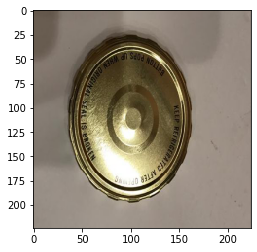

In [0]:
print("Training set shape: {}".format(x_train.shape))
print()

x = np.random.randint(1000)
print("One-hot encoding: {}".format(y_train[x]))
print("Class: {}".format(waste_types[np.argmax(y_train[x])]))
print("Image:")
imshow(x_train[x])


# Define Classification Model

In [0]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
     
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def ResNet50(input_shape=(512, 512, 3), classes=6):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# Train Classification Model

In [0]:
model = ResNet50(input_shape = (224, 224, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 59, batch_size = 64, validation_data=(x_valid, y_valid))

# save to file
model.save('run1.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3453 samples, validate on 740 samples
Epoch 1/59
3453/3453 [==============================] - 101s 29ms/step - loss: 3.1321 - acc: 0.2299 - val_loss: 2.5765 - val_acc: 0.3068
Epoch 2/59
3453/3453 [==============================] - 81s 24ms/step - loss: 1.9316 - acc: 0.3860 - val_loss: 1.7023 - val_acc: 0.3649
Epoch 3/59
1536/3453 [============>.................] - ETA: 42s - loss: 1.7962 - acc: 0.4238

KeyboardInterrupt: ignored

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test Classification Model

In [0]:
classification_model = load_model("/content/gdrive/My Drive/run1.h5")

preds = classification_model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

741/741 [==============================] - 8s 10ms/step
Loss = 0.9594726110437782
Test Accuracy = 0.7962213226979883


# Define Segmentation Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


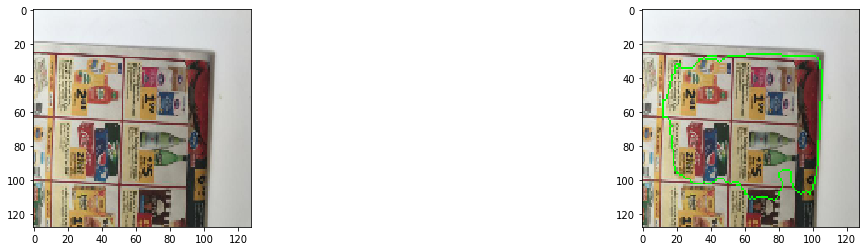

In [0]:
def unet(pretrained_weights = None,input_size = (128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Train Segmentation Model

In [0]:
# collect car training data
image_names = sorted([str(f) for f in os.listdir("/content/gdrive/My Drive/Colab Notebooks/car_data/input") if os.path.isfile(os.path.join("/content/gdrive/My Drive/Colab Notebooks/car_data/input", f))])
mask_names = sorted([str(f) for f in os.listdir("/content/gdrive/My Drive/Colab Notebooks/car_data/mask") if os.path.isfile(os.path.join("/content/gdrive/My Drive/Colab Notebooks/car_data/mask", f))])

images = []
masks = []

print("loading data")
for i in range(500):
    try:
        image = img_to_array(load_img("/content/gdrive/My Drive/Colab Notebooks/car_data/input/" + image_names[i], color_mode="grayscale", target_size=(128, 128))) / 255
        mask = img_to_array(load_img("/content/gdrive/My Drive/Colab Notebooks/car_data/mask/" + mask_names[i], color_mode="grayscale", target_size=(128, 128))) / 255

        images.append(image)
        masks.append(mask)
    except Exception as e:
        print(e)
        break
    
print("data loaded")
images, masks = np.array(images), np.array(masks)
print(len(images), len(masks))

# train model
model = unet()
model.fit(images, masks, batch_size=30, epochs=10) 
model.save("/content/gdrive/My Drive/Colab Notebooks/project_trained.h5")
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/project_trained_weights.h5')

# Final Output - Classification and Segmentation Results

In [0]:
# load model
classification_model = load_model("/content/gdrive/My Drive/run1.h5")
segmentation_model = load_model("/content/gdrive/My Drive/Colab Notebooks/project_trained.h5")


The image fed in was /content/gdrive/My Drive/dataset-resized/metal/metal60.jpg
According to the classifier, this is an image of metal
According to the segmenter, the metal in this image is located here: 


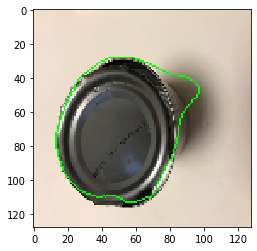

In [0]:
img_path = "/content/gdrive/My Drive/dataset-resized/metal/metal60.jpg"
print("The image fed in was {}".format(img_path))

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)/255.
x = np.expand_dims(x, axis=0)

classification_prediction = classification_model.predict(x)
print("According to the classifier, this is an image of {}".format(waste_types[np.argmax(classification_prediction)]))

img = load_img(img_path, color_mode="grayscale", target_size=(128, 128))
x = np.array([img_to_array(img) / 255])

segmentation_prediction = segmentation_model.predict(x)
segmentation_prediction[segmentation_prediction >= 0.3] = 1
segmentation_prediction[segmentation_prediction < 0.7] = 0
segmentation_prediction = segmentation_prediction.reshape(128, 128).astype("uint8")
(thresh, im_bw) = cv2.threshold(segmentation_prediction, 0.5, 1, 0)
_, contours, _ = cv2.findContours(im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img = image.load_img(img_path, target_size=(128, 128))
x = img_to_array(img)/255.
x = np.expand_dims(x, axis=0)

image_out = (cv2.drawContours(np.array(img), contours, -1, (0,255,0), 1)).astype("uint8")
print("According to the segmenter, the {} in this image is located here: ".format(waste_types[np.argmax(classification_prediction)]))
imshow(image_out)
